# Metabolic network analysis using *volestipy*

Aim of this notebook is to present the complete pipeline for random sampling in a metabolic network using the ```volesitpy``` library. As input, we will use a BIGG model of *E.coli* in its ```.json``` format. 

Other formats, such as ```.mat``` are supported by ```volestipy``` but this is not in the scope of this tutorial. 

**Attention!**
This tutorial assumes that you have already compiled the ```volestipy``` library, following the steps described [here](https://github.com/hariszaf/volume_approximation_bio/tree/develop/volestipy).

## Dependencies

With respect to this ```jupyter notebook```.
First you need to create a **conda environment** by making use of at least Python 3.6. 
Then open the notebook using the ```jupyter notebook``` command after entering the conda evironment you built. 

For example, considering that the base environment of ```conda``` includes Python 3.6:

```conda activate```

```jupyter notebook```

Before showing how you can exploit the *volestipy* software, we first need to get all the relative dependencies. 

This demo uses [Anaconda](https://www.anaconda.com/products/individual) which you can download following [these](https://www.digitalocean.com/community/tutorials/how-to-install-anaconda-on-ubuntu-18-04-quickstart) instructions.

Furtheremore, special, powerful mathematical optimization solvers like [Gurobi](https://www.gurobi.com/) are also used. You can get Gurobi following the steps described [here](https://support.gurobi.com/hc/en-us/articles/360044290292-Installing-Gurobi-for-Python). Keep in mind that you will need a Gurobi license. To do this, you need to create a Gurobi user account and then follow the instructions for a license you will find there.

The main libraries you need to run this pipeline are the following:

* ```numpy```
* ```gurobipy``` and of course
* ```volestipy```

You will also need a library for plotting, like ```matplotib``` but this is up to you!

To get any libraries that need to run commands as ```sudo``` you need to make a file including **only** your password and replace ```/home/haris/Desktop/running/metabolic_network_pipeline_volestipy/my_project_virtual_env/error.txt``` with the corresponding path. 

So, with respect to the ```numpy``` library, let us first get it in our conda environment. 
This is going to take a while. 

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} numpy


Solving environment: done

# All requested packages already installed.



Now we can import it. 

In [2]:
import numpy as np

In order to make possible to install what is needed in this conda evironment we use the ```getpass``` library that prompts the user for a password without echoing.

In [3]:
import getpass 
import os

In [ ]:
# Get GUROBI through anaconda - You can find more about installing Gurobi here: 
# https://support.gurobi.com/hc/en-us/articles/360044290292-Installing-Gurobi-for-Python
!conda install -y -c gurobi gurobi
print("*** The Gurobi solver library has now been installed *** \n\n")

Now we can import the ```gurobipy``` library and check if everything is working fine. 

In [4]:
import gurobipy as gp
from gurobipy import GRB

# This is just a test that the Gurobi solver is well installed

# Create a new model
m = gp.Model("mip1")

print("\n*** Gurobi test has been completed successfully. ***\n")

Using license file /home/haris/gurobi.lic
Academic license - for non-commercial use only

*** Gurobi test has been completed successfully. ***



In [5]:
!conda install --yes --prefix {sys.prefix} scipy

Solving environment: done

# All requested packages already installed.



Finally, we can now import the ```volestipy``` library. 

In [6]:
from volestipy import *

Now we are ready to read our network BIGG file and run the necessary steps to get our random points from its correspoding polytope.

## Read your network file

We have downloaded a BIGG model of *E. coli* which you may find [here](http://bigg.ucsd.edu/models/e_coli_core) in its ```.json``` format. We keep this file as a variable. 

In [7]:
input_file = '/home/haris/bigg_files/e_coli_core.json'

And we run the ```volestipy``` function to read it.

In [8]:
read_ecoli_core = read_json_file(input_file)

You may see the whole BIGG file, simply by printing the ```read_ecoli_core``` variable. 

In [ ]:
read_ecoli_core

As the ```read_ecoli_core``` variable is a tuple, we can get its different features in a straight forward way:

In [9]:
A = read_ecoli_core[0]
b = read_ecoli_core[1]
Aeq = read_ecoli_core[2]
beq = read_ecoli_core[3]

In the ```Aeq``` variable is the stoichiometric matrix of the metabolic network under study, while in the ```beq``` variable we have its steady state. The variables ```A``` and ```b``` allow us to represent the upper and the lower bounds of the reactions.

Let's have a look on these variables. ```Aeq``` our stoichiometric matrix has dimensions:

In [39]:
Aeq.shape

(72, 95)

meaning we have 72 metabolites that take part in 95 reactions. So, our network is built from these 95 reactions and their corresponding fluxes.

And let us also keep the reactions of the network in a variable. 

In [43]:
reactions = read_ecoli_core[5]

Now we can proceed in the necessary pre-processing steps for getting the polytope that derives from this metabolic network. 

## Preprocess

In terms of making things faster, we run a pre process step in order to run our pipeline in a more efficient, from a computational point of view, way.

In [10]:
proc = pre_process(A, b, Aeq, beq)

Minimize
   <gurobi.LinExpr: 0.0>
Subject To
   c[0] : <gurobi.LinExpr: x[0] + x[3] + x[11] + x[15] + x[16] + 2.0 x[19] + -1.0 x[21] + -1.0 x[23] + 59.81 x[24] + x[37] + x[74] + x[75]> = 0.0
   c[1] : <gurobi.LinExpr: -1.0 x[0] + -1.0 x[3] + -1.0 x[11] + -1.0 x[15] + -1.0 x[16] + -1.0 x[18] + -1.0 x[19] + x[21] + x[23] + -59.81 x[24] + -1.0 x[37] + -1.0 x[74] + -1.0 x[75]> = 0.0
   c[2] : <gurobi.LinExpr: -1.0 x[0] + x[2] + -0.0709 x[24] + x[38] + x[41] + x[64] + x[68]> = 0.0
   c[3] : <gurobi.LinExpr: x[0] + -1.0 x[63] + -1.0 x[64]> = 0.0
   c[4] : <gurobi.LinExpr: x[0] + x[4] + x[5] + x[6] + x[8] + x[9] + x[12] + x[15] + x[17] + 2.0 x[18] + 3.0 x[21] + -1.0 x[23] + 59.81 x[24] + x[25] + x[28] + 2.0 x[30] + -2.0 x[31] + x[32] + x[34] + x[35] + 2.0 x[39] + x[65] + 2.0 x[70] + x[71] + x[72] + x[74] + x[75] + x[76] + -1.0 x[78] + x[79] + x[84] + x[85] + 2.0 x[86] + x[87] + -4.0 x[90]> = 0.0
   c[5] : <gurobi.LinExpr: x[1] + x[5] + -1.0 x[22] + -3.7478 x[24] + -1.0 x[28] + -1.0 x[85] + x[

   x[52]  free
   x[53]  free
   x[54]  free
   x[55]  free
   x[56]  free
   x[57]  free
   x[58]  free
   x[59]  free
   x[60]  free
   x[61]  free
   x[62]  free
   x[63]  free
   x[64]  free
   x[65]  free
   x[66]  free
   x[67]  free
   x[68]  free
   x[69]  free
   x[70]  free
   x[71]  free
   x[72]  free
   x[73]  free
   x[74]  free
   x[75]  free
   x[76]  free
   x[77]  free
   x[78]  free
   x[79]  free
   x[80]  free
   x[81]  free
   x[82]  free
   x[83]  free
   x[84]  free
   x[85]  free
   x[86]  free
   x[87]  free
   x[88]  free
   x[89]  free
   x[90]  free
   x[91]  free
   x[92]  free
   x[93]  free
   x[94]  free


From this, we get the processed A, b, Aeq and beq and we keep them in distinct variables correspodingly.

In [11]:
A_proc = proc[0]
b_proc = proc[1]
Aeq_proc = proc[2]
beq_proc = proc[3]

## Full dimensional (not always required step)

Now we are able to use the pre processed polytope to get the full dimensional polytope that derives from our initial one. To this end we first build an object for the ```low_dim_HPolytope``` class for the pre-processed polytope. 

In [12]:
low_hp = low_dim_HPolytope(A_proc, b_proc, Aeq_proc, beq_proc)

And then we run the ```full_dimensiolal_polytope``` function of ```volestipy``` to get it. 

In [14]:
get_fd_hp = low_hp.full_dimensiolal_polytope()

A_fd = get_fd_hp[0].A
b_fd = get_fd_hp[0].b
N = get_fd_hp[1]
N_shift = get_fd_hp[2]

Once we have the full dimensional polytope, we are able to get the max ball of that.

In [20]:
max_ball_center_point, max_ball_radius = get_max_ball(A_fd, b_fd)

Now we can use this max ball for rounding the full dimensional polytope. 

## Rounding

Using the A and b of the full dimensional polytope, we build a new HPolytope object.

In [21]:
hp = HPolytope(A_fd, b_fd)

And we use the max ball to round it.

In [22]:
rounding_output_max_ellipsoid = hp.rounding(rounding_method = "max_ellipsoid", 
                                            inner_point = max_ball_center_point, 
                                            radius = max_ball_radius)

We can now get the features or the rounded polytope.

In [23]:
rounded_A = rounding_output_max_ellipsoid[0]
rounded_b = rounding_output_max_ellipsoid[1]
rounded_T = rounding_output_max_ellipsoid[2]
rounded_shift = rounding_output_max_ellipsoid[3]

And use the to get the max ball of this full dimensional, rounded polytope.

In [24]:
rounded_center_point, rounded_radius = get_max_ball(rounded_A, rounded_b)

Let's have a look at that:

In [25]:
rounded_center_point

[-1.0827203738869838e-08,
 5.46699607224613e-09,
 -1.9440816473264214e-09,
 4.202258767454394e-09,
 -5.720196183334541e-09,
 -2.34495800347931e-09,
 3.4714599880184695e-09,
 -1.0610740112672796e-10,
 1.5374959601778526e-09,
 6.363085780165716e-09,
 7.47879143571297e-09,
 4.875192491832598e-10,
 -1.5540451275577207e-09,
 1.8233604962779356e-09,
 -6.1940535936238185e-09,
 -3.027059547527763e-10,
 5.372701921624584e-09,
 1.8968608527828443e-09,
 8.502848362572111e-10,
 1.4118646354600406e-09,
 -6.156855514982069e-10,
 8.125766689870477e-10,
 5.389284100671947e-10,
 -1.7114008103486753e-10]

In [26]:
rounded_radius

1.0000000081541534

## Sampling

Finally, we build the full dimenionsal rounded polytope. 

In [27]:
rounded_polytope = HPolytope(rounded_A, rounded_b)

And using the latter max ball, we sample on it

In [28]:
samples = rounded_polytope.generate_samples(walk_len = 5, 
                                            number_of_points = 10000, 
                                            number_of_points_to_burn = 50, 
                                            radius = rounded_radius, 
                                            inner_point = rounded_center_point)

And these are the points sampled: 

In [29]:
samples

array([[-1.08272037e-08, -5.37904316e-01, -1.94408165e-09, ...,
         8.12576669e-10,  1.05232535e+00, -1.71140081e-10],
       [-1.08272037e-08, -5.37904316e-01, -1.94408165e-09, ...,
         8.12576669e-10, -7.19713111e-01, -1.71140081e-10],
       [ 3.07248252e-02, -5.37904316e-01, -1.94408165e-09, ...,
        -3.92408940e-02, -2.14932031e-01, -1.71140081e-10],
       ...,
       [ 4.44814180e-01, -6.51613145e-01, -6.69751574e-01, ...,
        -7.96801293e-01, -1.73044267e+00,  1.68765003e+00],
       [ 5.24991962e-01, -6.51613145e-01, -6.69751574e-01, ...,
        -6.00621603e-01, -1.73044267e+00,  1.68765003e+00],
       [ 5.24991962e-01, -6.51613145e-01, -6.69751574e-01, ...,
        -8.36059088e-01, -1.73044267e+00,  1.68765003e+00]])

However, these samples "live" in the world of the rounded, full dimensional polytope. Thus, we need to map them back in our initial polyopte. To do that we run one last ```volestipy``` function, using the features returned from the ```rounding``` and the ```full_dimensional``` functions. 

In [46]:
mapped_samples = map_samples_on_initial_polytope(samples, rounded_T, rounded_shift, N, N_shift)

Let's have a look on our final points and their dimension. 

In [47]:
mapped_samples.shape

(95, 10000)

## Analysis, plots etc.

We will use the ```matplotlib``` library to plot our random samples. First, we download it to our environment.

In [33]:
pip install matplotlib

     |████████████████████████████████| 11.6 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 1.1 MB/s eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
     |████████████████████████████████| 2.2 MB 431 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Now we can import it.

In [35]:
import matplotlib.pyplot as plt

Let us assume now that we are insteresd in the Ethanol reversible transport via proton symport reaction. This is called ```ETOHt2r```. As you can see, this is the 36th element in our ```reactions``` list.

In [45]:
reactions[35]

'ETOHt2r'

We keep all the fluxes' values from the points sampled for this reactions in a variable.

In [52]:
fluxes = mapped_samples[35:,]
fluxes.shape

(60, 10000)

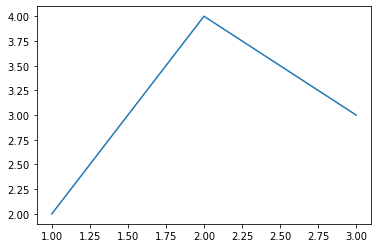

In [36]:
plt.plot([1, 2, 3], [2, 4, 3])
 
plt.show()

## Extras

In case you need to work with ```.mat``` files you need to implement some further steps that are not in the interest of this tutorial. 

To read a ```.mat``` file you need some extra Python libraries, as it is quite a challenging task. If you are more interested in that, you can read this article [here](https://scipy-cookbook.readthedocs.io/items/Reading_mat_files.html).

In [ ]:
# Get the h5py library in case you are working with .mat files of 7.3 release of Matlab and after 
!sudo -H -S pip install h5py < /home/haris/Desktop/running/metabolic_network_pipeline_volestipy/\
my_project_virtual_env/error.txt
print("*** The h5py library has now been installed *** \n\n")

In [ ]:
# Get the tables library to read .mat files
!sudo -H -S pip3 install tables < /home/haris/Desktop/running/metabolic_network_pipeline_volestipy\
/my_project_virtual_env/error.txt
print("*** The tables library has now been installed *** \n\n")

In [ ]:
# Matlab up to 7.1 = mat files created with Matlab up to version 7.1 can be read using the mio module part of scipy.io.
from scipy.io import loadmat 

# Beginning at release 7.3 of Matlab, mat files are actually saved using the HDF5 format by default (except if you use the -vX flag at save time, see in Matlab). These files can be read in Python using, for instance, the PyTables or h5py package
import tables 
import h5py

In [ ]:
# Get the ggplot - oriented Python library
!sudo -H -S pip3 install -t "/home/haris/anaconda3/lib/python3.7/site-packages/" --upgrade pandas plotnine \
< /home/haris/Desktop/running/metabolic_network_pipeline_volestipy/my_project_virtual_env/error.txt
print("*** The ggplot for Python library has now been installed *** \n\n")

In [ ]:
mat_file_with_loadmat = loadmat('/home/haris/Downloads/e_coli_core.mat')

While this one is in case of ```.mat``` files created by releases of Matlab later after the 7.3
This command will not run in any other case.
For this demo we will use the ```loadmat``` option.

In [ ]:
# mat_file_with_tables = h5py.File('/home/haris/Downloads/e_coli_core.mat')

Now you can see your metabolic network. 

In [ ]:
print(mat_file_with_loadmat)

In [ ]:
data_from_mat = mat_file_with_loadmat
print("the data type of the variable with the network as it was read is: " + str(type(data_from_mat)))

s_matrix = data_from_mat.keys()
print("\nthe keys of this dictionaries are: ")
print(s_matrix)

e_coli_np_void = data_from_mat['e_coli_core'][0][0]
print("\nHowever, if we keep the key:value pair of this dictionary, called 'e_coli_core' where the necessary \
information is located, we can see that its type is: " + str(type(e_coli_np_void)) + "\n\n")

print("number of dimensions of the np.void data type equals to:" + str(e_coli_np_void.ndim) + "\n")

print(type(e_coli_np_void))
print(len(e_coli_np_void))



# metabolites
print(type(e_coli_np_void[0]))
print(e_coli_np_void[0].shape)

print(type(e_coli_np_void[0][0]))
print(e_coli_np_void[0][0].shape)

print(e_coli_np_void[0][:3,])
metabolites = [item[0][0] for item in e_coli_np_void[0]]
print(metabolites)

# genes
print(type(e_coli_np_void[4]))
print(e_coli_np_void[4].shape)
print(e_coli_np_void[4][:3,])

# reactions
print(type(e_coli_np_void[7]))
print(e_coli_np_void[7].shape)
print(e_coli_np_void[7][:3,])

In [ ]:
for key,value in data_from_mat.items():
    print(str(key) + "\t" + str(value))
    print("\n\n\n\n\n\n")